In [33]:
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
import os
import sys
sys.path.append("../")
import random
from aif360.algorithms.inprocessing.gerryfair_classifier import *
from aif360.algorithms.inprocessing.gerryfair.clean import *
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import *
from aif360.algorithms.inprocessing.gerryfair.auditor import *
from sklearn import svm
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt



We first demonstrate how to instantiate a `Model`, `train` it with respect to rich subgroup fairness, and `predict` the label of a new example. We remark that when we set the `print_flag = True` at each iteration of the algorithm we print the error, fairness violation, and violated group size of most recent model. The error is the classification error of the classifier. At each round the Learner tries to find a classifier that minimizes the classification error plus a weighted sum of the fairness disparities on all the groups that the Auditor has found up until that point. By contrast the Auditor tries to find the group at each round with the greatest rich subgroup disparity with respect to the Learner's model. We define `violated group size` as the size (as a fraction of the dataset size) of this group, and the `fairness violation` as the `violated group size` times the difference in the statistical rate (FP or FN rate) on the group vs. the whole population. 

In the example below we set `max_iterations=5000` which is in-line with time to convergence observed in [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166), but advise that this can be highly dataset dependent. Our target $\gamma$-disparity is `gamma = .001`, our statistical rate is false positive rate or `FP`, and our weighted regression oracle is linear regression. We observe that the unconstrained (with no fairness constraint) classifier has error $.185$ and $\gamma$-disparity $.022$. After $5000$ iterations we obtain a classifier that $\gamma$-fair, and has error $.230$. We note that we converge to a fair, and almost as accurate classifier after just a hundred iterations.


In [26]:
C = 10
print_flag = True
gamma = .001
max_iterations = 5000

fair_model = Model(C=C, printflag=print_flag, gamma=gamma, fairness_def='FP',
             max_iters=max_iterations, heatmapflag=False)
data_set = load_preproc_data_adult(sub_samp=200)

# fit method
communities_all_errors, communities_violations = fair_model.fit(data_set,
                                                 early_termination=True, return_values=True)
# predict method
dataset_yhat = fair_model.predict(data_set)



iteration: 1
most accurate classifier error: 0.185, most accurate class unfairness: 0.02205882352941177, violated group size: 0.39
iteration: 2
error: 0.21, fairness violation: 0.011029411764705885, violated group size: 0.39
iteration: 3
error: 0.21833333333333335, fairness violation: 0.007352941176470589, violated group size: 0.39
iteration: 4
error: 0.2225, fairness violation: 0.005514705882352942, violated group size: 0.39
iteration: 5
error: 0.225, fairness violation: 0.004411764705882354, violated group size: 0.39
iteration: 6
error: 0.22666666666666666, fairness violation: 0.0036764705882352962, violated group size: 0.39
iteration: 7
error: 0.22785714285714284, fairness violation: 0.003151260504201681, violated group size: 0.375
iteration: 8
error: 0.22875, fairness violation: 0.002757352941176472, violated group size: 0.39
iteration: 9
error: 0.22944444444444442, fairness violation: 0.0024509803921568627, violated group size: 0.375
iteration: 10
error: 0.23, fairness violation: 

iteration: 77
error: 0.23071428571428573, fairness violation: 0.0011777438248026485, violated group size: 0.375
iteration: 78
error: 0.23051282051282052, fairness violation: 0.0012254901960784314, violated group size: 0.375
iteration: 79
error: 0.23031645569620252, fairness violation: 0.0012720277984611568, violated group size: 0.375
iteration: 80
error: 0.23037500000000002, fairness violation: 0.0012561274509803925, violated group size: 0.375
iteration: 81
error: 0.23043209876543208, fairness violation: 0.0012406197046719927, violated group size: 0.39
iteration: 82
error: 0.23048780487804876, fairness violation: 0.0012254901960784318, violated group size: 0.39
iteration: 83
error: 0.23054216867469882, fairness violation: 0.001210725253957005, violated group size: 0.375
iteration: 84
error: 0.2305952380952381, fairness violation: 0.0011963118580765647, violated group size: 0.39
iteration: 85
error: 0.23064705882352943, fairness violation: 0.0011822376009227229, violated group size: 0.3

iteration: 151
error: 0.2310927152317881, fairness violation: 0.0010225944682508768, violated group size: 0.375
iteration: 152
error: 0.23098684210526316, fairness violation: 0.0010481166150670806, violated group size: 0.39
iteration: 153
error: 0.23088235294117646, fairness violation: 0.0010733051390490842, violated group size: 0.39
iteration: 154
error: 0.23077922077922075, fairness violation: 0.0010981665393430104, violated group size: 0.375
iteration: 155
error: 0.2306774193548387, fairness violation: 0.0011227071473750795, violated group size: 0.375
iteration: 156
error: 0.23057692307692307, fairness violation: 0.0011469331322272506, violated group size: 0.39
iteration: 157
error: 0.23060509554140127, fairness violation: 0.0011396278256525544, violated group size: 0.375
iteration: 158
error: 0.23063291139240505, fairness violation: 0.0011324149913129811, violated group size: 0.375
iteration: 159
error: 0.23066037735849057, fairness violation: 0.0011252928844493776, violated group 

iteration: 226
error: 0.2314159292035398, fairness violation: 0.0009218289085545729, violated group size: 0.375
iteration: 227
error: 0.23134361233480177, fairness violation: 0.0009393625291526308, violated group size: 0.39
iteration: 228
error: 0.2312719298245614, fairness violation: 0.0009567423460612323, violated group size: 0.39
iteration: 229
error: 0.23120087336244538, fairness violation: 0.000973970374175872, violated group size: 0.39
iteration: 230
error: 0.2311304347826087, fairness violation: 0.0009910485933503845, violated group size: 0.375
iteration: 231
error: 0.23106060606060608, fairness violation: 0.0010079789491554204, violated group size: 0.375
iteration: 232
error: 0.23099137931034483, fairness violation: 0.00102476335361731, violated group size: 0.39
iteration: 233
error: 0.2309227467811159, fairness violation: 0.0010414036859378954, violated group size: 0.375
iteration: 234
error: 0.23085470085470086, fairness violation: 0.001057901793195912, violated group size: 0

iteration: 300
error: 0.2314333333333333, fairness violation: 0.0009068627450980403, violated group size: 0.39
iteration: 301
error: 0.2313787375415282, fairness violation: 0.0009201354960588894, violated group size: 0.375
iteration: 302
error: 0.23132450331125828, fairness violation: 0.0009333203480067529, violated group size: 0.39
iteration: 303
error: 0.2312706270627063, fairness violation: 0.0009464181712288881, violated group size: 0.375
iteration: 304
error: 0.23121710526315786, fairness violation: 0.0009594298245614041, violated group size: 0.375
iteration: 305
error: 0.2311639344262295, fairness violation: 0.0009723561555769856, violated group size: 0.39
iteration: 306
error: 0.2311111111111111, fairness violation: 0.0009851980007689358, violated group size: 0.375
iteration: 307
error: 0.2310586319218241, fairness violation: 0.000997956185731622, violated group size: 0.375
iteration: 308
error: 0.2310064935064935, fairness violation: 0.0010106315253374085, violated group size: 

iteration: 374
error: 0.23144385026737968, fairness violation: 0.0008978190206563913, violated group size: 0.39
iteration: 375
error: 0.23145333333333334, fairness violation: 0.0008954248366013076, violated group size: 0.375
iteration: 376
error: 0.2314627659574468, fairness violation: 0.0008930433875677934, violated group size: 0.375
iteration: 377
error: 0.23147214854111403, fairness violation: 0.0008906745722161547, violated group size: 0.375
iteration: 378
error: 0.23142857142857143, fairness violation: 0.0009012864405021272, violated group size: 0.375
iteration: 379
error: 0.23138522427440633, fairness violation: 0.0009118423094831605, violated group size: 0.39
iteration: 380
error: 0.2313421052631579, fairness violation: 0.0009223426212590306, violated group size: 0.39
iteration: 381
error: 0.23129921259842523, fairness violation: 0.0009327878132880456, violated group size: 0.39
iteration: 382
error: 0.23125654450261784, fairness violation: 0.0009431783184477986, violated group s

iteration: 448
error: 0.23131696428571427, fairness violation: 0.0009245885854341737, violated group size: 0.39
iteration: 449
error: 0.2313251670378619, fairness violation: 0.0009225293680946775, violated group size: 0.39
iteration: 450
error: 0.23133333333333334, fairness violation: 0.0009204793028322443, violated group size: 0.375
iteration: 451
error: 0.23134146341463413, fairness violation: 0.0009184383287683146, violated group size: 0.39
iteration: 452
error: 0.2313495575221239, fairness violation: 0.000916406385563075, violated group size: 0.375
iteration: 453
error: 0.23135761589403972, fairness violation: 0.0009143834134095143, violated group size: 0.39
iteration: 454
error: 0.23136563876651983, fairness violation: 0.0009123693530275546, violated group size: 0.375
iteration: 455
error: 0.2313296703296703, fairness violation: 0.0009211376858435684, violated group size: 0.375
iteration: 456
error: 0.2312938596491228, fairness violation: 0.000929867561059512, violated group size:

iteration: 523
error: 0.23123326959847038, fairness violation: 0.0009419637836013951, violated group size: 0.39
iteration: 524
error: 0.23124045801526716, fairness violation: 0.0009401661427929956, violated group size: 0.39
iteration: 525
error: 0.23124761904761904, fairness violation: 0.0009383753501400568, violated group size: 0.39
iteration: 526
error: 0.23125475285171102, fairness violation: 0.0009365913665846572, violated group size: 0.375
iteration: 527
error: 0.2312618595825427, fairness violation: 0.0009348141533653316, violated group size: 0.375
iteration: 528
error: 0.23126893939393942, fairness violation: 0.0009330436720142607, violated group size: 0.375
iteration: 529
error: 0.2312759924385633, fairness violation: 0.0009312798843544985, violated group size: 0.39
iteration: 530
error: 0.2312830188679245, fairness violation: 0.0009295227524972259, violated group size: 0.375
iteration: 531
error: 0.2312900188323917, fairness violation: 0.0009277722388390389, violated group siz

iteration: 598
error: 0.2311705685618729, fairness violation: 0.0009549806544691462, violated group size: 0.375
iteration: 599
error: 0.23117696160267112, fairness violation: 0.000953386362892403, violated group size: 0.375
iteration: 600
error: 0.23118333333333332, fairness violation: 0.0009517973856209158, violated group size: 0.375
iteration: 601
error: 0.23118968386023295, fairness violation: 0.0009502136961273701, violated group size: 0.375
iteration: 602
error: 0.23119601328903655, fairness violation: 0.0009486352680607137, violated group size: 0.39
iteration: 603
error: 0.23120232172470978, fairness violation: 0.0009470620752446922, violated group size: 0.375
iteration: 604
error: 0.23120860927152317, fairness violation: 0.0009454940916764064, violated group size: 0.375
iteration: 605
error: 0.23121487603305785, fairness violation: 0.0009439312915248755, violated group size: 0.39
iteration: 606
error: 0.2312211221122112, fairness violation: 0.0009423736491296198, violated group 

iteration: 673
error: 0.2311218424962853, fairness violation: 0.0009650962911167448, violated group size: 0.375
iteration: 674
error: 0.23112759643916914, fairness violation: 0.0009636643975097466, violated group size: 0.375
iteration: 675
error: 0.23113333333333333, fairness violation: 0.0009622367465504727, violated group size: 0.375
iteration: 676
error: 0.23113905325443784, fairness violation: 0.0009608133194106053, violated group size: 0.39
iteration: 677
error: 0.2311447562776957, fairness violation: 0.0009593940973730711, violated group size: 0.375
iteration: 678
error: 0.23115044247787608, fairness violation: 0.0009579790618312232, violated group size: 0.39
iteration: 679
error: 0.23115611192930782, fairness violation: 0.0009565681942880254, violated group size: 0.375
iteration: 680
error: 0.23116176470588237, fairness violation: 0.0009551614763552488, violated group size: 0.375
iteration: 681
error: 0.23116740088105725, fairness violation: 0.0009537588897526717, violated group

iteration: 748
error: 0.23108288770053473, fairness violation: 0.0009731833910034618, violated group size: 0.375
iteration: 749
error: 0.23108811748998664, fairness violation: 0.0009718840807350992, violated group size: 0.39
iteration: 750
error: 0.23109333333333332, fairness violation: 0.0009705882352941194, violated group size: 0.39
iteration: 751
error: 0.23109853528628496, fairness violation: 0.0009692958408396665, violated group size: 0.39
iteration: 752
error: 0.23110372340425528, fairness violation: 0.000968006883604507, violated group size: 0.375
iteration: 753
error: 0.23110889774236387, fairness violation: 0.0009667213498945411, violated group size: 0.39
iteration: 754
error: 0.23111405835543772, fairness violation: 0.000965439226088315, violated group size: 0.375
iteration: 755
error: 0.23111920529801325, fairness violation: 0.0009641604986365424, violated group size: 0.375
iteration: 756
error: 0.2311243386243386, fairness violation: 0.0009628851540616262, violated group si

iteration: 823
error: 0.2310753341433779, fairness violation: 0.0009738403259238093, violated group size: 0.375
iteration: 824
error: 0.23108009708737864, fairness violation: 0.0009726584808680764, violated group size: 0.39
iteration: 825
error: 0.2310848484848485, fairness violation: 0.0009714795008912669, violated group size: 0.39
iteration: 826
error: 0.23108958837772395, fairness violation: 0.0009703033755875246, violated group size: 0.39
iteration: 827
error: 0.23109431680773881, fairness violation: 0.0009691300946013241, violated group size: 0.375
iteration: 828
error: 0.2310990338164251, fairness violation: 0.0009679596476271679, violated group size: 0.39
iteration: 829
error: 0.23110373944511461, fairness violation: 0.0009667920244092823, violated group size: 0.375
iteration: 830
error: 0.23110843373493978, fairness violation: 0.0009656272147413193, violated group size: 0.375
iteration: 831
error: 0.23111311672683513, fairness violation: 0.0009644652084660589, violated group si

iteration: 898
error: 0.23104677060133627, fairness violation: 0.0009798462814970094, violated group size: 0.39
iteration: 899
error: 0.23105116796440492, fairness violation: 0.0009787563523740983, violated group size: 0.39
iteration: 900
error: 0.23105555555555554, fairness violation: 0.000977668845315905, violated group size: 0.39
iteration: 901
error: 0.23105993340732517, fairness violation: 0.0009765837522578405, violated group size: 0.375
iteration: 902
error: 0.23106430155210642, fairness violation: 0.00097550106517108, violated group size: 0.375
iteration: 903
error: 0.2310686600221484, fairness violation: 0.0009744207760623637, violated group size: 0.39
iteration: 904
error: 0.2310730088495575, fairness violation: 0.000973342876973799, violated group size: 0.375
iteration: 905
error: 0.23107734806629834, fairness violation: 0.0009722673599826677, violated group size: 0.39
iteration: 906
error: 0.23108167770419427, fairness violation: 0.0009711942172012299, violated group size: 

iteration: 972
error: 0.2310185185185185, fairness violation: 0.0009859396433470505, violated group size: 0.375
iteration: 973
error: 0.23102261048304215, fairness violation: 0.0009849263446385745, violated group size: 0.39
iteration: 974
error: 0.23102669404517454, fairness violation: 0.0009839151266255984, violated group size: 0.375
iteration: 975
error: 0.23103076923076923, fairness violation: 0.0009829059829059826, violated group size: 0.375
iteration: 976
error: 0.23103483606557376, fairness violation: 0.0009818989071038245, violated group size: 0.375
iteration: 977
error: 0.2310388945752303, fairness violation: 0.0009808938928693273, violated group size: 0.375
iteration: 978
error: 0.23104294478527607, fairness violation: 0.0009798909338786634, violated group size: 0.39
iteration: 979
error: 0.23104698672114402, fairness violation: 0.0009788900238338434, violated group size: 0.375
iteration: 980
error: 0.23105102040816328, fairness violation: 0.0009778911564625847, violated group

iteration: 1045
error: 0.23095215311004785, fairness violation: 0.0010015010789004588, violated group size: 0.375
iteration: 1046
error: 0.2309560229445507, fairness violation: 0.0010005436208900377, violated group size: 0.375
iteration: 1047
error: 0.2309598853868195, fairness violation: 0.0009995879918347464, violated group size: 0.375
iteration: 1048
error: 0.2309637404580153, fairness violation: 0.000998634186499026, violated group size: 0.375
iteration: 1049
error: 0.2309675881792183, fairness violation: 0.0009976821996672827, violated group size: 0.375
iteration: 1050
error: 0.23097142857142855, fairness violation: 0.00099673202614379, violated group size: 0.375
iteration: 1051
error: 0.23097526165556612, fairness violation: 0.000995783660752597, violated group size: 0.39
iteration: 1052
error: 0.23097908745247145, fairness violation: 0.0009948370983374332, violated group size: 0.39
iteration: 1053
error: 0.230982905982906, fairness violation: 0.0009938923337616137, violated grou

iteration: 1118
error: 0.23087656529516998, fairness violation: 0.0010194149216037032, violated group size: 0.39
iteration: 1119
error: 0.23088025022341377, fairness violation: 0.0010185039163118318, violated group size: 0.375
iteration: 1120
error: 0.23088392857142856, fairness violation: 0.0010175945378151246, violated group size: 0.375
iteration: 1121
error: 0.23088760035682426, fairness violation: 0.001016686781759982, violated group size: 0.375
iteration: 1122
error: 0.23089126559714795, fairness violation: 0.0010157806438083241, violated group size: 0.375
iteration: 1123
error: 0.23089492430988423, fairness violation: 0.0010148761196375243, violated group size: 0.39
iteration: 1124
error: 0.23089857651245552, fairness violation: 0.0010139732049403377, violated group size: 0.375
iteration: 1125
error: 0.23090222222222223, fairness violation: 0.0010130718954248353, violated group size: 0.375
iteration: 1126
error: 0.23090586145648312, fairness violation: 0.0010121721868143335, viol

iteration: 1191
error: 0.2310285474391268, fairness violation: 0.0009816269076900273, violated group size: 0.375
iteration: 1192
error: 0.23101510067114095, fairness violation: 0.000984915778391893, violated group size: 0.39
iteration: 1193
error: 0.2310016764459346, fairness violation: 0.000988199135479841, violated group size: 0.39
iteration: 1194
error: 0.23098827470686767, fairness violation: 0.0009914769928071724, violated group size: 0.375
iteration: 1195
error: 0.23097489539748955, fairness violation: 0.0009947493641808184, violated group size: 0.39
iteration: 1196
error: 0.23096153846153847, fairness violation: 0.0009980162633615312, violated group size: 0.375
iteration: 1197
error: 0.23094820384294068, fairness violation: 0.001001277704064081, violated group size: 0.375
iteration: 1198
error: 0.23093489148580967, fairness violation: 0.0010045336999574446, violated group size: 0.375
iteration: 1199
error: 0.23092160133444536, fairness violation: 0.0010077842646649979, violated 

iteration: 1264
error: 0.23106803797468356, fairness violation: 0.000971472449739388, violated group size: 0.375
iteration: 1265
error: 0.23107114624505928, fairness violation: 0.0009707044873285268, violated group size: 0.375
iteration: 1266
error: 0.23107424960505532, fairness violation: 0.0009699377381284257, violated group size: 0.39
iteration: 1267
error: 0.23107734806629834, fairness violation: 0.0009691721992664455, violated group size: 0.375
iteration: 1268
error: 0.23108044164037855, fairness violation: 0.0009684078678790114, violated group size: 0.375
iteration: 1269
error: 0.23108353033884949, fairness violation: 0.0009676447411115733, violated group size: 0.375
iteration: 1270
error: 0.23108661417322834, fairness violation: 0.0009668828161185721, violated group size: 0.375
iteration: 1271
error: 0.23108969315499606, fairness violation: 0.000966122090063404, violated group size: 0.39
iteration: 1272
error: 0.23109276729559747, fairness violation: 0.0009653625601183857, viola

iteration: 1337
error: 0.23101346297681377, fairness violation: 0.000984425183686038, violated group size: 0.375
iteration: 1338
error: 0.23101644245142006, fairness violation: 0.0009836894399015193, violated group size: 0.375
iteration: 1339
error: 0.23101941747572816, fairness violation: 0.0009829547950621605, violated group size: 0.375
iteration: 1340
error: 0.23102238805970152, fairness violation: 0.0009822212467076364, violated group size: 0.39
iteration: 1341
error: 0.23102535421327366, fairness violation: 0.0009814887923849612, violated group size: 0.375
iteration: 1342
error: 0.2310283159463487, fairness violation: 0.0009807574296484601, violated group size: 0.39
iteration: 1343
error: 0.2310312732688012, fairness violation: 0.0009800271560597416, violated group size: 0.375
iteration: 1344
error: 0.2310342261904762, fairness violation: 0.0009792979691876731, violated group size: 0.375
iteration: 1345
error: 0.2310371747211896, fairness violation: 0.0009785698666083516, violated

iteration: 1410
error: 0.2309503546099291, fairness violation: 0.0009995132804894989, violated group size: 0.375
iteration: 1411
error: 0.23095322466335932, fairness violation: 0.0009988049082141697, violated group size: 0.375
iteration: 1412
error: 0.23095609065155806, fairness violation: 0.0009980975392990038, violated group size: 0.375
iteration: 1413
error: 0.23095895258315643, fairness violation: 0.000997391171613725, violated group size: 0.39
iteration: 1414
error: 0.23096181046676098, fairness violation: 0.000996685803034083, violated group size: 0.375
iteration: 1415
error: 0.23096466431095408, fairness violation: 0.0009959814314418327, violated group size: 0.375
iteration: 1416
error: 0.2309675141242938, fairness violation: 0.0009952780547247129, violated group size: 0.375
iteration: 1417
error: 0.23097035991531406, fairness violation: 0.0009945756707764246, violated group size: 0.39
iteration: 1418
error: 0.2309732016925247, fairness violation: 0.0009938742774966104, violated

iteration: 1483
error: 0.23087997302764665, fairness violation: 0.0010164214033556755, violated group size: 0.375
iteration: 1484
error: 0.2308827493261456, fairness violation: 0.001015736483272552, violated group size: 0.375
iteration: 1485
error: 0.2308855218855219, fairness violation: 0.0010150524856407184, violated group size: 0.375
iteration: 1486
error: 0.23088829071332437, fairness violation: 0.001014369408597892, violated group size: 0.39
iteration: 1487
error: 0.2308910558170814, fairness violation: 0.0010136872502867968, violated group size: 0.375
iteration: 1488
error: 0.23089381720430108, fairness violation: 0.0010130060088551524, violated group size: 0.375
iteration: 1489
error: 0.23089657488247148, fairness violation: 0.0010123256824556527, violated group size: 0.375
iteration: 1490
error: 0.23089932885906045, fairness violation: 0.001011646269245951, violated group size: 0.375
iteration: 1491
error: 0.23090207914151578, fairness violation: 0.0010109677673886433, violated

iteration: 1556
error: 0.231073264781491, fairness violation: 0.0009687358233781921, violated group size: 0.39
iteration: 1557
error: 0.2310757867694284, fairness violation: 0.0009681136423740955, violated group size: 0.39
iteration: 1558
error: 0.23107830551989733, fairness violation: 0.000967492260061917, violated group size: 0.375
iteration: 1559
error: 0.23108082103912764, fairness violation: 0.0009668716749047254, violated group size: 0.375
iteration: 1560
error: 0.23108333333333334, fairness violation: 0.0009662518853695301, violated group size: 0.375
iteration: 1561
error: 0.23108584240871238, fairness violation: 0.0009656328899272693, violated group size: 0.39
iteration: 1562
error: 0.23107554417413576, fairness violation: 0.0009681529461976833, violated group size: 0.39
iteration: 1563
error: 0.23106525911708253, fairness violation: 0.0009706697778279554, violated group size: 0.375
iteration: 1564
error: 0.23105498721227619, fairness violation: 0.0009731833910034581, violated 

iteration: 1629
error: 0.2309914057704113, fairness violation: 0.0009885169537428207, violated group size: 0.39
iteration: 1630
error: 0.23099386503067484, fairness violation: 0.0009879105016239599, violated group size: 0.375
iteration: 1631
error: 0.23099632127529127, fairness violation: 0.0009873047931618975, violated group size: 0.39
iteration: 1632
error: 0.23099877450980394, fairness violation: 0.000986699826989617, violated group size: 0.375
iteration: 1633
error: 0.2310012247397428, fairness violation: 0.0009860956017434508, violated group size: 0.39
iteration: 1634
error: 0.23100367197062424, fairness violation: 0.0009854921160630688, violated group size: 0.375
iteration: 1635
error: 0.23100611620795106, fairness violation: 0.0009848893685914708, violated group size: 0.375
iteration: 1636
error: 0.23100855745721277, fairness violation: 0.0009842873579749725, violated group size: 0.39
iteration: 1637
error: 0.23101099572388517, fairness violation: 0.000983686082863198, violated 

iteration: 1703
error: 0.23091896652965352, fairness violation: 0.0010060101550896316, violated group size: 0.375
iteration: 1704
error: 0.23092136150234743, fairness violation: 0.0010054197735432176, violated group size: 0.375
iteration: 1705
error: 0.23092375366568915, fairness violation: 0.0010048300845264767, violated group size: 0.375
iteration: 1706
error: 0.23092614302461897, fairness violation: 0.001004241086821596, violated group size: 0.39
iteration: 1707
error: 0.23092852958406568, fairness violation: 0.001003652779213616, violated group size: 0.375
iteration: 1708
error: 0.23093091334894617, fairness violation: 0.0010030651604904233, violated group size: 0.39
iteration: 1709
error: 0.23093329432416618, fairness violation: 0.0010024782294427402, violated group size: 0.375
iteration: 1710
error: 0.2309356725146199, fairness violation: 0.0010018919848641188, violated group size: 0.39
iteration: 1711
error: 0.23093804792518996, fairness violation: 0.0010013064255509308, violate

iteration: 1776
error: 0.23098536036036038, fairness violation: 0.0009895005299417042, violated group size: 0.39
iteration: 1777
error: 0.23097636465953855, fairness violation: 0.0009917022520882276, violated group size: 0.375
iteration: 1778
error: 0.23096737907761533, fairness violation: 0.0009939014976069146, violated group size: 0.375
iteration: 1779
error: 0.2309584035975267, fairness violation: 0.0009960982706742033, violated group size: 0.375
iteration: 1780
error: 0.2309494382022472, fairness violation: 0.0009982925754571468, violated group size: 0.375
iteration: 1781
error: 0.23094048287478944, fairness violation: 0.0010004844161134391, violated group size: 0.375
iteration: 1782
error: 0.23093153759820428, fairness violation: 0.0010026737967914416, violated group size: 0.375
iteration: 1783
error: 0.23092260235558051, fairness violation: 0.001004860721630209, violated group size: 0.375
iteration: 1784
error: 0.23091367713004485, fairness violation: 0.0010070451947595156, viola

iteration: 1849
error: 0.23101406165494864, fairness violation: 0.0009822479559698388, violated group size: 0.375
iteration: 1850
error: 0.2310162162162162, fairness violation: 0.0009817170111287741, violated group size: 0.375
iteration: 1851
error: 0.23101836844948678, fairness violation: 0.0009811866399720324, violated group size: 0.39
iteration: 1852
error: 0.23102051835853132, fairness violation: 0.0009806568415703196, violated group size: 0.375
iteration: 1853
error: 0.23102266594711282, fairness violation: 0.0009801276149963476, violated group size: 0.375
iteration: 1854
error: 0.231024811218986, fairness violation: 0.0009795989593248287, violated group size: 0.39
iteration: 1855
error: 0.23102695417789756, fairness violation: 0.00097907087363247, violated group size: 0.375
iteration: 1856
error: 0.23102909482758618, fairness violation: 0.0009785433569979702, violated group size: 0.39
iteration: 1857
error: 0.23103123317178245, fairness violation: 0.0009780164085020095, violated 

iteration: 1923
error: 0.23094903796151847, fairness violation: 0.000997981095714415, violated group size: 0.375
iteration: 1924
error: 0.23095114345114345, fairness violation: 0.0009974623945212164, violated group size: 0.39
iteration: 1925
error: 0.23095324675324677, fairness violation: 0.0009969442322383482, violated group size: 0.375
iteration: 1926
error: 0.23095534787123573, fairness violation: 0.0009964266080263867, violated group size: 0.39
iteration: 1927
error: 0.23095744680851063, fairness violation: 0.0009959095210476492, violated group size: 0.375
iteration: 1928
error: 0.23095954356846474, fairness violation: 0.000995392970466193, violated group size: 0.375
iteration: 1929
error: 0.2309616381544842, fairness violation: 0.0009948769554478072, violated group size: 0.375
iteration: 1930
error: 0.2309637305699482, fairness violation: 0.0009943614751600103, violated group size: 0.375
iteration: 1931
error: 0.2309658208182289, fairness violation: 0.0009938465287720455, violated

iteration: 1997
error: 0.23087881822734105, fairness violation: 0.0010150028965016137, violated group size: 0.375
iteration: 1998
error: 0.23088088088088088, fairness violation: 0.001014494887043905, violated group size: 0.375
iteration: 1999
error: 0.23088294147073538, fairness violation: 0.0010139873858497862, violated group size: 0.375
iteration: 2000
error: 0.230885, fairness violation: 0.0010134803921568614, violated group size: 0.39
iteration: 2001
error: 0.2308870564717641, fairness violation: 0.0010129739052042593, violated group size: 0.375
iteration: 2002
error: 0.2308891108891109, fairness violation: 0.001012467924232629, violated group size: 0.39
iteration: 2003
error: 0.23089116325511733, fairness violation: 0.0010119624484841352, violated group size: 0.375
iteration: 2004
error: 0.23089321357285428, fairness violation: 0.0010114574772024565, violated group size: 0.375
iteration: 2005
error: 0.23089526184538656, fairness violation: 0.0010109530096327794, violated group siz

iteration: 2071
error: 0.2310260743602125, fairness violation: 0.0009787352893837389, violated group size: 0.375
iteration: 2072
error: 0.2310279922779923, fairness violation: 0.0009782629267923375, violated group size: 0.39
iteration: 2073
error: 0.23102990834539316, fairness violation: 0.000977791019929437, violated group size: 0.375
iteration: 2074
error: 0.2310318225650916, fairness violation: 0.0009773195681358354, violated group size: 0.375
iteration: 2075
error: 0.23103373493975904, fairness violation: 0.0009768485707536015, violated group size: 0.39
iteration: 2076
error: 0.23103564547206165, fairness violation: 0.0009763780271260709, violated group size: 0.375
iteration: 2077
error: 0.23103755416466057, fairness violation: 0.000975907936597845, violated group size: 0.39
iteration: 2078
error: 0.23103946102021172, fairness violation: 0.0009754382985147847, violated group size: 0.39
iteration: 2079
error: 0.23104136604136605, fairness violation: 0.0009749691122240128, violated g

iteration: 2145
error: 0.23096736596736597, fairness violation: 0.0009929612870789332, violated group size: 0.39
iteration: 2146
error: 0.23096924510717615, fairness violation: 0.0009924985837764732, violated group size: 0.375
iteration: 2147
error: 0.23097112249650675, fairness violation: 0.0009920363114971173, violated group size: 0.375
iteration: 2148
error: 0.23097299813780262, fairness violation: 0.0009915744696388786, violated group size: 0.375
iteration: 2149
error: 0.23097487203350398, fairness violation: 0.0009911130576008892, violated group size: 0.39
iteration: 2150
error: 0.23097674418604655, fairness violation: 0.0009906520747834007, violated group size: 0.375
iteration: 2151
error: 0.23097861459786145, fairness violation: 0.0009901915205877783, violated group size: 0.375
iteration: 2152
error: 0.23098048327137546, fairness violation: 0.0009897313944165016, violated group size: 0.375
iteration: 2153
error: 0.23098235020901067, fairness violation: 0.000989271695673159, viol

iteration: 2219
error: 0.23093059936908517, fairness violation: 0.0010018202864742096, violated group size: 0.39
iteration: 2220
error: 0.23093243243243244, fairness violation: 0.0010013690160748966, violated group size: 0.375
iteration: 2221
error: 0.2309342638451148, fairness violation: 0.001000918152042445, violated group size: 0.375
iteration: 2222
error: 0.23093609360936093, fairness violation: 0.0010004676938282044, violated group size: 0.39
iteration: 2223
error: 0.2309379217273954, fairness violation: 0.001000017640884512, violated group size: 0.375
iteration: 2224
error: 0.23093974820143884, fairness violation: 0.00099956799266469, violated group size: 0.39
iteration: 2225
error: 0.23094157303370788, fairness violation: 0.000999118748623043, violated group size: 0.39
iteration: 2226
error: 0.2309433962264151, fairness violation: 0.0009986699082148566, violated group size: 0.39
iteration: 2227
error: 0.23094521778176919, fairness violation: 0.0009982214708963945, violated group

iteration: 2293
error: 0.23090492804186658, fairness violation: 0.0010079696946375567, violated group size: 0.39
iteration: 2294
error: 0.23090671316477768, fairness violation: 0.0010075303006991795, violated group size: 0.39
iteration: 2295
error: 0.23090849673202615, fairness violation: 0.0010070912896749096, violated group size: 0.39
iteration: 2296
error: 0.23091027874564463, fairness violation: 0.001006652661064424, violated group size: 0.375
iteration: 2297
error: 0.23091205920766217, fairness violation: 0.0010062144143682704, violated group size: 0.375
iteration: 2298
error: 0.2309138381201044, fairness violation: 0.0010057765490878666, violated group size: 0.375
iteration: 2299
error: 0.23091561548499345, fairness violation: 0.0010053390647254972, violated group size: 0.39
iteration: 2300
error: 0.23091739130434782, fairness violation: 0.0010049019607843118, violated group size: 0.375
iteration: 2301
error: 0.23091916558018255, fairness violation: 0.001004465236768326, violated

iteration: 2367
error: 0.23094845796366711, fairness violation: 0.0009971669276075431, violated group size: 0.375
iteration: 2368
error: 0.230941722972973, fairness violation: 0.000998815911499733, violated group size: 0.375
iteration: 2369
error: 0.23093499366821446, fairness violation: 0.001000463503256936, violated group size: 0.375
iteration: 2370
error: 0.23092827004219407, fairness violation: 0.0010021097046413485, violated group size: 0.375
iteration: 2371
error: 0.23092155208772674, fairness violation: 0.0010037545174121929, violated group size: 0.375
iteration: 2372
error: 0.2309148397976391, fairness violation: 0.0010053979433257264, violated group size: 0.375
iteration: 2373
error: 0.23090813316477032, fairness violation: 0.001007039984135245, violated group size: 0.375
iteration: 2374
error: 0.23090143218197134, fairness violation: 0.0010086806415910913, violated group size: 0.375
iteration: 2375
error: 0.23089473684210524, fairness violation: 0.0010103199174406588, violate

iteration: 2441
error: 0.23100573535436297, fairness violation: 0.0009830027873500872, violated group size: 0.375
iteration: 2442
error: 0.23100737100737098, fairness violation: 0.0009826002473061275, violated group size: 0.375
iteration: 2443
error: 0.23100900532132626, fairness violation: 0.0009821980368078442, violated group size: 0.375
iteration: 2444
error: 0.23101063829787233, fairness violation: 0.0009817961554507216, violated group size: 0.39
iteration: 2445
error: 0.23101226993865034, fairness violation: 0.0009813946028309057, violated group size: 0.39
iteration: 2446
error: 0.2310139002452985, fairness violation: 0.0009809933785452016, violated group size: 0.375
iteration: 2447
error: 0.23100735594605643, fairness violation: 0.0009825957354744083, violated group size: 0.375
iteration: 2448
error: 0.23100081699346403, fairness violation: 0.0009841967832884767, violated group size: 0.375
iteration: 2449
error: 0.23099428338097183, fairness violation: 0.0009857965235910591, viol

iteration: 2515
error: 0.2309801192842942, fairness violation: 0.0009891630608505802, violated group size: 0.39
iteration: 2516
error: 0.23098171701112882, fairness violation: 0.0009887699117802897, violated group size: 0.39
iteration: 2517
error: 0.2309833134684148, fairness violation: 0.00098837707510497, violated group size: 0.39
iteration: 2518
error: 0.23098490865766483, fairness violation: 0.0009879845504524262, violated group size: 0.375
iteration: 2519
error: 0.23098650258038908, fairness violation: 0.0009875923374510556, violated group size: 0.39
iteration: 2520
error: 0.23098809523809524, fairness violation: 0.0009872004357298447, violated group size: 0.375
iteration: 2521
error: 0.23098968663228878, fairness violation: 0.0009868088449183697, violated group size: 0.39
iteration: 2522
error: 0.23099127676447267, fairness violation: 0.0009864175646467918, violated group size: 0.39
iteration: 2523
error: 0.23099286563614743, fairness violation: 0.0009860265945458616, violated gr

iteration: 2589
error: 0.23095596755504055, fairness violation: 0.0009949711827566072, violated group size: 0.375
iteration: 2590
error: 0.23095752895752894, fairness violation: 0.000994587023998786, violated group size: 0.375
iteration: 2591
error: 0.2309590891547665, fairness violation: 0.000994203161774163, violated group size: 0.375
iteration: 2592
error: 0.23096064814814818, fairness violation: 0.0009938195957395278, violated group size: 0.375
iteration: 2593
error: 0.23096220593906672, fairness violation: 0.0009934363255522005, violated group size: 0.375
iteration: 2594
error: 0.2309637625289129, fairness violation: 0.0009930533508700295, violated group size: 0.375
iteration: 2595
error: 0.23096531791907515, fairness violation: 0.0009926706713513898, violated group size: 0.375
iteration: 2596
error: 0.23096687211093994, fairness violation: 0.0009922882866551836, violated group size: 0.375
iteration: 2597
error: 0.2309684251058914, fairness violation: 0.0009919061964408383, violat

iteration: 2662
error: 0.23092411720510897, fairness violation: 0.0010026737967914424, violated group size: 0.375
iteration: 2663
error: 0.23092564776567784, fairness violation: 0.00100229727640211, violated group size: 0.375
iteration: 2664
error: 0.23092717717717717, fairness violation: 0.0010019210386857432, violated group size: 0.375
iteration: 2665
error: 0.23092870544090058, fairness violation: 0.001001545083324135, violated group size: 0.39
iteration: 2666
error: 0.23093023255813955, fairness violation: 0.0010011694099995572, violated group size: 0.39
iteration: 2667
error: 0.23093175853018372, fairness violation: 0.001000794018394758, violated group size: 0.39
iteration: 2668
error: 0.23093328335832086, fairness violation: 0.0010004189081929608, violated group size: 0.375
iteration: 2669
error: 0.23093480704383665, fairness violation: 0.0010000440790778645, violated group size: 0.39
iteration: 2670
error: 0.230936329588015, fairness violation: 0.0009996695307336403, violated gr

iteration: 2735
error: 0.2309012797074954, fairness violation: 0.001008172921819549, violated group size: 0.39
iteration: 2736
error: 0.23089546783625728, fairness violation: 0.0010095960898979456, violated group size: 0.375
iteration: 2737
error: 0.23089696748264527, fairness violation: 0.0010092272202998828, violated group size: 0.375
iteration: 2738
error: 0.23089846603360115, fairness violation: 0.0010088586201463768, violated group size: 0.375
iteration: 2739
error: 0.23089996349032496, fairness violation: 0.0010084902891423074, violated group size: 0.39
iteration: 2740
error: 0.23090145985401458, fairness violation: 0.0010081222269929854, violated group size: 0.375
iteration: 2741
error: 0.2309029551258665, fairness violation: 0.0010077544334041518, violated group size: 0.39
iteration: 2742
error: 0.23090444930707513, fairness violation: 0.0010073869080819767, violated group size: 0.39
iteration: 2743
error: 0.23090594239883339, fairness violation: 0.0010070196507330586, violated

iteration: 2809
error: 0.23100213599145605, fairness violation: 0.0009833588116627918, violated group size: 0.39
iteration: 2810
error: 0.2310035587188612, fairness violation: 0.000983008861907752, violated group size: 0.39
iteration: 2811
error: 0.23100498043400924, fairness violation: 0.000982659161138663, violated group size: 0.375
iteration: 2812
error: 0.23099928876244666, fairness violation: 0.0009840529383873028, violated group size: 0.375
iteration: 2813
error: 0.23099360113757555, fairness violation: 0.000985445724681624, violated group size: 0.375
iteration: 2814
error: 0.23098791755508175, fairness violation: 0.0009868375210780817, violated group size: 0.375
iteration: 2815
error: 0.2309822380106572, fairness violation: 0.0009882283286316291, violated group size: 0.375
iteration: 2816
error: 0.2309765625, fairness violation: 0.0009896181483957207, violated group size: 0.375
iteration: 2817
error: 0.23097089101881432, fairness violation: 0.000991006981422316, violated group s

iteration: 2882
error: 0.230971547536433, fairness violation: 0.0009907675769822153, violated group size: 0.39
iteration: 2883
error: 0.2309729448491155, fairness violation: 0.0009904239184400775, violated group size: 0.375
iteration: 2884
error: 0.2309743411927878, fairness violation: 0.0009900804982187045, violated group size: 0.375
iteration: 2885
error: 0.23097573656845755, fairness violation: 0.0009897373160702753, violated group size: 0.39
iteration: 2886
error: 0.23097713097713096, fairness violation: 0.0009893943717473124, violated group size: 0.375
iteration: 2887
error: 0.23097852441981295, fairness violation: 0.0009890516650026824, violated group size: 0.375
iteration: 2888
error: 0.23097991689750694, fairness violation: 0.0009887091955895926, violated group size: 0.375
iteration: 2889
error: 0.23098130841121495, fairness violation: 0.0009883669632615938, violated group size: 0.39
iteration: 2890
error: 0.2309826989619377, fairness violation: 0.000988024967772576, violated g

iteration: 2955
error: 0.2309492385786802, fairness violation: 0.00099615142165157, violated group size: 0.39
iteration: 2956
error: 0.23095060893098782, fairness violation: 0.000995814428613122, violated group size: 0.375
iteration: 2957
error: 0.23095197835644235, fairness violation: 0.0009954776635036826, violated group size: 0.39
iteration: 2958
error: 0.2309533468559838, fairness violation: 0.0009951411260920853, violated group size: 0.375
iteration: 2959
error: 0.23095471443055085, fairness violation: 0.0009948048161474785, violated group size: 0.39
iteration: 2960
error: 0.2309560810810811, fairness violation: 0.0009944687334393206, violated group size: 0.375
iteration: 2961
error: 0.23095744680851063, fairness violation: 0.0009941328777373826, violated group size: 0.39
iteration: 2962
error: 0.2309588116137745, fairness violation: 0.0009937972488117456, violated group size: 0.39
iteration: 2963
error: 0.23096017549780629, fairness violation: 0.000993461846432801, violated group

iteration: 3029
error: 0.23092934962033673, fairness violation: 0.0010009451122806323, violated group size: 0.375
iteration: 3030
error: 0.23093069306930694, fairness violation: 0.0010006147673590877, violated group size: 0.39
iteration: 3031
error: 0.2309320356318047, fairness violation: 0.0010002846404150558, violated group size: 0.375
iteration: 3032
error: 0.23093337730870714, fairness violation: 0.000999954731232861, violated group size: 0.375
iteration: 3033
error: 0.2309347181008902, fairness violation: 0.0009996250395971102, violated group size: 0.39
iteration: 3034
error: 0.23093605800922873, fairness violation: 0.0009992955652926943, violated group size: 0.375
iteration: 3035
error: 0.23093739703459637, fairness violation: 0.0009989663081047889, violated group size: 0.375
iteration: 3036
error: 0.23093873517786562, fairness violation: 0.000998637267818852, violated group size: 0.39
iteration: 3037
error: 0.2309400724399078, fairness violation: 0.0009983084442206239, violated 

iteration: 3102
error: 0.23090264345583494, fairness violation: 0.0010074145712443566, violated group size: 0.375
iteration: 3103
error: 0.2309039639058975, fairness violation: 0.0010070899129874299, violated group size: 0.39
iteration: 3104
error: 0.23090528350515463, fairness violation: 0.001006765463917524, violated group size: 0.375
iteration: 3105
error: 0.23090660225442836, fairness violation: 0.0010064412238325266, violated group size: 0.375
iteration: 3106
error: 0.2309079201545396, fairness violation: 0.0010061171925305843, violated group size: 0.375
iteration: 3107
error: 0.23090923720630832, fairness violation: 0.0010057933698101047, violated group size: 0.39
iteration: 3108
error: 0.23091055341055342, fairness violation: 0.0010054697554697535, violated group size: 0.375
iteration: 3109
error: 0.23091186876809264, fairness violation: 0.0010051463493084578, violated group size: 0.39
iteration: 3110
error: 0.23091318327974278, fairness violation: 0.0010048231511254001, violate

iteration: 3175
error: 0.23098425196850392, fairness violation: 0.0009873398178168887, violated group size: 0.375
iteration: 3176
error: 0.23097921914357683, fairness violation: 0.0009885723810934936, violated group size: 0.375
iteration: 3177
error: 0.23097418948693738, fairness violation: 0.0009898041684410607, violated group size: 0.39
iteration: 3178
error: 0.23096916299559475, fairness violation: 0.000991035180592059, violated group size: 0.375
iteration: 3179
error: 0.2309641396665618, fairness violation: 0.0009922654182780361, violated group size: 0.375
iteration: 3180
error: 0.23095911949685535, fairness violation: 0.0009934948822296198, violated group size: 0.375
iteration: 3181
error: 0.23095410248349574, fairness violation: 0.0009947235731765185, violated group size: 0.39
iteration: 3182
error: 0.23094908862350721, fairness violation: 0.0009959514918475231, violated group size: 0.375
iteration: 3183
error: 0.23094407791391766, fairness violation: 0.0009971786389705098, viola

iteration: 3248
error: 0.2309698275862069, fairness violation: 0.0009908058050806508, violated group size: 0.39
iteration: 3249
error: 0.2309710680209295, fairness violation: 0.0009905008479230387, violated group size: 0.39
iteration: 3250
error: 0.2309723076923077, fairness violation: 0.00099019607843137, violated group size: 0.375
iteration: 3251
error: 0.23097354660104585, fairness violation: 0.0009898914964324677, violated group size: 0.375
iteration: 3252
error: 0.23097478474784747, fairness violation: 0.000989587101753368, violated group size: 0.375
iteration: 3253
error: 0.2309760221334153, fairness violation: 0.0009892828942213194, violated group size: 0.375
iteration: 3254
error: 0.23097725875845115, fairness violation: 0.0009889788736637836, violated group size: 0.375
iteration: 3255
error: 0.2309784946236559, fairness violation: 0.000988675039908434, violated group size: 0.39
iteration: 3256
error: 0.23097972972972972, fairness violation: 0.0009883713927831552, violated grou

iteration: 3321
error: 0.23094399277326105, fairness violation: 0.0009970715175561318, violated group size: 0.375
iteration: 3322
error: 0.23094521372667068, fairness violation: 0.0009967713756182763, violated group size: 0.39
iteration: 3323
error: 0.2309464339452302, fairness violation: 0.0009964714143255835, violated group size: 0.375
iteration: 3324
error: 0.2309476534296029, fairness violation: 0.0009961716335150162, violated group size: 0.375
iteration: 3325
error: 0.23094887218045113, fairness violation: 0.0009958720330237336, violated group size: 0.375
iteration: 3326
error: 0.2309500901984366, fairness violation: 0.0009955726126890901, violated group size: 0.375
iteration: 3327
error: 0.23095130748422002, fairness violation: 0.0009952733723486366, violated group size: 0.39
iteration: 3328
error: 0.23095252403846153, fairness violation: 0.0009949743118401189, violated group size: 0.39
iteration: 3329
error: 0.23095373986182038, fairness violation: 0.000994675431001476, violated

iteration: 3394
error: 0.23091926929876255, fairness violation: 0.0010030676973205286, violated group size: 0.375
iteration: 3395
error: 0.23092047128129603, fairness violation: 0.0010027722429177834, violated group size: 0.375
iteration: 3396
error: 0.2309216725559482, fairness violation: 0.0010024769625164532, violated group size: 0.375
iteration: 3397
error: 0.23092287312334414, fairness violation: 0.0010021818559628718, violated group size: 0.375
iteration: 3398
error: 0.23092407298410833, fairness violation: 0.0010018869231035537, violated group size: 0.375
iteration: 3399
error: 0.23092527213886435, fairness violation: 0.0010015921637851943, violated group size: 0.375
iteration: 3400
error: 0.23092647058823532, fairness violation: 0.0010012975778546694, violated group size: 0.39
iteration: 3401
error: 0.23092766833284328, fairness violation: 0.0010010031651590341, violated group size: 0.375
iteration: 3402
error: 0.23092886537330984, fairness violation: 0.0010007089255455247, vio

iteration: 3468
error: 0.23091983852364478, fairness violation: 0.00100286654454169, violated group size: 0.39
iteration: 3469
error: 0.2309152493513981, fairness violation: 0.0010039905267382227, violated group size: 0.375
iteration: 3470
error: 0.23091066282420752, fairness violation: 0.0010051138611064001, violated group size: 0.375
iteration: 3471
error: 0.2309060789397868, fairness violation: 0.001006236548206143, violated group size: 0.375
iteration: 3472
error: 0.23090149769585253, fairness violation: 0.001007358588596727, violated group size: 0.375
iteration: 3473
error: 0.2309026778001728, fairness violation: 0.0010070685342953747, violated group size: 0.375
iteration: 3474
error: 0.2309038572251008, fairness violation: 0.0010067786469798033, violated group size: 0.39
iteration: 3475
error: 0.23090503597122303, fairness violation: 0.0010064889265058521, violated group size: 0.375
iteration: 3476
error: 0.23090621403912542, fairness violation: 0.0010061993727295275, violated gr

iteration: 3541
error: 0.2309813611974019, fairness violation: 0.0009877291780875006, violated group size: 0.39
iteration: 3542
error: 0.23098249576510446, fairness violation: 0.0009874503160948159, violated group size: 0.39
iteration: 3543
error: 0.23098362969235112, fairness violation: 0.000987171611517877, violated group size: 0.375
iteration: 3544
error: 0.23098476297968396, fairness violation: 0.0009868930642234304, violated group size: 0.375
iteration: 3545
error: 0.2309802538787024, fairness violation: 0.0009879974556818482, violated group size: 0.39
iteration: 3546
error: 0.230975747320925, fairness violation: 0.0009891012242460421, violated group size: 0.375
iteration: 3547
error: 0.2309712433042007, fairness violation: 0.0009902043704428471, violated group size: 0.375
iteration: 3548
error: 0.23096674182638108, fairness violation: 0.000991306894798504, violated group size: 0.375
iteration: 3549
error: 0.23096224288531983, fairness violation: 0.0009924087978386603, violated gr

iteration: 3615
error: 0.23096403872752422, fairness violation: 0.00099191820573319, violated group size: 0.375
iteration: 3616
error: 0.23096515486725663, fairness violation: 0.0009916438920701005, violated group size: 0.39
iteration: 3617
error: 0.23096627038982587, fairness violation: 0.0009913697300872222, violated group size: 0.39
iteration: 3618
error: 0.23096738529574354, fairness violation: 0.0009910957196587844, violated group size: 0.375
iteration: 3619
error: 0.23096849958552088, fairness violation: 0.000990821860659155, violated group size: 0.39
iteration: 3620
error: 0.23096961325966853, fairness violation: 0.0009905481529628405, violated group size: 0.39
iteration: 3621
error: 0.2309707263186965, fairness violation: 0.0009902745964444856, violated group size: 0.375
iteration: 3622
error: 0.2309718387631143, fairness violation: 0.000990001190978874, violated group size: 0.375
iteration: 3623
error: 0.23097295059343087, fairness violation: 0.000989727936440928, violated gro

iteration: 3688
error: 0.23094631236442517, fairness violation: 0.0009962092212155986, violated group size: 0.375
iteration: 3689
error: 0.23094741122255358, fairness violation: 0.0009959391726329977, violated group size: 0.39
iteration: 3690
error: 0.23094850948509488, fairness violation: 0.000995669270418192, violated group size: 0.375
iteration: 3691
error: 0.2309496071525332, fairness violation: 0.0009953995144522157, violated group size: 0.39
iteration: 3692
error: 0.23095070422535216, fairness violation: 0.0009951299046162317, violated group size: 0.375
iteration: 3693
error: 0.23095180070403468, fairness violation: 0.0009948604407915322, violated group size: 0.39
iteration: 3694
error: 0.23095289658906332, fairness violation: 0.0009945911228595365, violated group size: 0.375
iteration: 3695
error: 0.23095399188092017, fairness violation: 0.0009943219507017938, violated group size: 0.375
iteration: 3696
error: 0.23095508658008657, fairness violation: 0.0009940529241999805, violat

iteration: 3761
error: 0.2309239563945759, fairness violation: 0.001001637028116216, violated group size: 0.375
iteration: 3762
error: 0.2309250398724083, fairness violation: 0.0010013707769125704, violated group size: 0.39
iteration: 3763
error: 0.23092612277438218, fairness violation: 0.001001104667218998, violated group size: 0.39
iteration: 3764
error: 0.23092720510095646, fairness violation: 0.0010008386989227122, violated group size: 0.375
iteration: 3765
error: 0.23092828685258965, fairness violation: 0.001000572871911046, violated group size: 0.39
iteration: 3766
error: 0.23092936802973982, fairness violation: 0.001000307186071452, violated group size: 0.39
iteration: 3767
error: 0.23093044863286438, fairness violation: 0.001000041641291502, violated group size: 0.39
iteration: 3768
error: 0.23093152866242037, fairness violation: 0.0009997762374588876, violated group size: 0.375
iteration: 3769
error: 0.2309326081188644, fairness violation: 0.000999510974461419, violated group 

iteration: 3835
error: 0.23091395045632335, fairness violation: 0.0010040391645576058, violated group size: 0.39
iteration: 3836
error: 0.23091501564129302, fairness violation: 0.0010037774233781068, violated group size: 0.39
iteration: 3837
error: 0.2309160802710451, fairness violation: 0.0010035158186287247, violated group size: 0.375
iteration: 3838
error: 0.23091714434601357, fairness violation: 0.0010032543502028182, violated group size: 0.375
iteration: 3839
error: 0.23091820786663195, fairness violation: 0.0010029930179938568, violated group size: 0.375
iteration: 3840
error: 0.23091927083333336, fairness violation: 0.001002731821895421, violated group size: 0.39
iteration: 3841
error: 0.23092033324655042, fairness violation: 0.001002470761801202, violated group size: 0.375
iteration: 3842
error: 0.2309213951067153, fairness violation: 0.0010022098376050016, violated group size: 0.39
iteration: 3843
error: 0.2309224564142597, fairness violation: 0.001001949049200733, violated gr

iteration: 3908
error: 0.2309186284544524, fairness violation: 0.0010028448431573201, violated group size: 0.375
iteration: 3909
error: 0.23091967255052445, fairness violation: 0.0010025882954870322, violated group size: 0.39
iteration: 3910
error: 0.230920716112532, fairness violation: 0.0010023318790431733, violated group size: 0.375
iteration: 3911
error: 0.23092175914088472, fairness violation: 0.001002075593725085, violated group size: 0.375
iteration: 3912
error: 0.23092280163599185, fairness violation: 0.0010018194394322106, violated group size: 0.375
iteration: 3913
error: 0.2309238435982622, fairness violation: 0.0010015634160640962, violated group size: 0.39
iteration: 3914
error: 0.23092488502810427, fairness violation: 0.0010013075235203906, violated group size: 0.39
iteration: 3915
error: 0.23092592592592595, fairness violation: 0.001001051761700845, violated group size: 0.375
iteration: 3916
error: 0.23092696629213486, fairness violation: 0.0010007961305053133, violated g

iteration: 3981
error: 0.23093820648078375, fairness violation: 0.0009980003053720813, violated group size: 0.375
iteration: 3982
error: 0.23093922651933702, fairness violation: 0.0009977496774701796, violated group size: 0.39
iteration: 3983
error: 0.2309402460456942, fairness violation: 0.0009974991754170865, violated group size: 0.375
iteration: 3984
error: 0.23094126506024096, fairness violation: 0.000997248799118036, violated group size: 0.375
iteration: 3985
error: 0.23094228356336263, fairness violation: 0.0009969985484783576, violated group size: 0.375
iteration: 3986
error: 0.23094330155544404, fairness violation: 0.000996748423403476, violated group size: 0.375
iteration: 3987
error: 0.23094431903686985, fairness violation: 0.00099649842379891, violated group size: 0.375
iteration: 3988
error: 0.23094533600802408, fairness violation: 0.0009962485495702746, violated group size: 0.375
iteration: 3989
error: 0.2309463524692906, fairness violation: 0.0009959988006232776, violated

iteration: 4054
error: 0.23093734583127776, fairness violation: 0.0009981669036632861, violated group size: 0.375
iteration: 4055
error: 0.23093341553637486, fairness violation: 0.0009991296148545686, violated group size: 0.375
iteration: 4056
error: 0.23092948717948722, fairness violation: 0.0010000918513361908, violated group size: 0.39
iteration: 4057
error: 0.2309255607591817, fairness violation: 0.0010010536134591826, violated group size: 0.39
iteration: 4058
error: 0.23092163627402662, fairness violation: 0.0010020149015742279, violated group size: 0.375
iteration: 4059
error: 0.23091771372259182, fairness violation: 0.001002975716031666, violated group size: 0.39
iteration: 4060
error: 0.23091871921182267, fairness violation: 0.0010027286776779633, violated group size: 0.375
iteration: 4061
error: 0.23091972420586063, fairness violation: 0.0010024817609880648, violated group size: 0.375
iteration: 4062
error: 0.2309207287050714, fairness violation: 0.001002234965872115, violated

iteration: 4127
error: 0.23093651562878606, fairness violation: 0.0009983276082422268, violated group size: 0.375
iteration: 4128
error: 0.23093750000000005, fairness violation: 0.0009980857653138736, violated group size: 0.375
iteration: 4129
error: 0.23093848389440544, fairness violation: 0.000997844039529104, violated group size: 0.375
iteration: 4130
error: 0.23093946731234866, fairness violation: 0.000997602430802826, violated group size: 0.375
iteration: 4131
error: 0.23094045025417578, fairness violation: 0.0009973609390500292, violated group size: 0.375
iteration: 4132
error: 0.23094143272023238, fairness violation: 0.000997119564185787, violated group size: 0.39
iteration: 4133
error: 0.2309424147108638, fairness violation: 0.000996878306125253, violated group size: 0.39
iteration: 4134
error: 0.2309433962264151, fairness violation: 0.0009966371647836653, violated group size: 0.39
iteration: 4135
error: 0.230944377267231, fairness violation: 0.0009963961400763412, violated gro

iteration: 4200
error: 0.2309547619047619, fairness violation: 0.0009938141923435998, violated group size: 0.375
iteration: 4201
error: 0.2309509640561771, fairness violation: 0.0009947444819394032, violated group size: 0.375
iteration: 4202
error: 0.23094716801523085, fairness violation: 0.0009956743287510108, violated group size: 0.375
iteration: 4203
error: 0.23094337378063287, fairness violation: 0.000996603733094471, violated group size: 0.39
iteration: 4204
error: 0.23093958135109421, fairness violation: 0.0009975326952855314, violated group size: 0.39
iteration: 4205
error: 0.23093579072532702, fairness violation: 0.0009984612156396404, violated group size: 0.375
iteration: 4206
error: 0.23093200190204471, fairness violation: 0.0009993892944719454, violated group size: 0.375
iteration: 4207
error: 0.23092821487996196, fairness violation: 0.0010003169320972937, violated group size: 0.375
iteration: 4208
error: 0.2309244296577947, fairness violation: 0.0010012441288302352, violate

iteration: 4273
error: 0.23093025977065296, fairness violation: 0.0009997797387150459, violated group size: 0.375
iteration: 4274
error: 0.23093121197941038, fairness violation: 0.00099954581739106, violated group size: 0.375
iteration: 4275
error: 0.23093216374269013, fairness violation: 0.0009993120055039513, violated group size: 0.375
iteration: 4276
error: 0.23093311506080455, fairness violation: 0.0009990783029769391, violated group size: 0.375
iteration: 4277
error: 0.23093406593406596, fairness violation: 0.0009988447097333158, violated group size: 0.375
iteration: 4278
error: 0.23093501636278638, fairness violation: 0.000998611225696445, violated group size: 0.375
iteration: 4279
error: 0.23093596634727742, fairness violation: 0.000998377850789762, violated group size: 0.375
iteration: 4280
error: 0.23093691588785048, fairness violation: 0.000998144584936774, violated group size: 0.39
iteration: 4281
error: 0.23093786498481664, fairness violation: 0.0009979114280610588, violate

iteration: 4346
error: 0.2309526000920387, fairness violation: 0.0009942656307806103, violated group size: 0.375
iteration: 4347
error: 0.2309535311709225, fairness violation: 0.0009940369062278655, violated group size: 0.375
iteration: 4348
error: 0.23095446182152712, fairness violation: 0.0009938082868842068, violated group size: 0.375
iteration: 4349
error: 0.23095539204414808, fairness violation: 0.0009935797726770596, violated group size: 0.375
iteration: 4350
error: 0.23095172413793105, fairness violation: 0.0009944782510705396, violated group size: 0.39
iteration: 4351
error: 0.23094805791772008, fairness violation: 0.0009953763164654472, violated group size: 0.39
iteration: 4352
error: 0.23094439338235292, fairness violation: 0.0009962739691464786, violated group size: 0.39
iteration: 4353
error: 0.2309407305306685, fairness violation: 0.0009971712093980673, violated group size: 0.375
iteration: 4354
error: 0.23093706936150668, fairness violation: 0.000998068037504387, violated

iteration: 4420
error: 0.23093891402714933, fairness violation: 0.0009975822908348825, violated group size: 0.375
iteration: 4421
error: 0.23093530875367566, fairness violation: 0.0009984654345791665, violated group size: 0.375
iteration: 4422
error: 0.2309317051108096, fairness violation: 0.0009993481788916345, violated group size: 0.375
iteration: 4423
error: 0.23092810309744516, fairness violation: 0.0010002305240432113, violated group size: 0.39
iteration: 4424
error: 0.23092450271247741, fairness violation: 0.0010011124703045743, violated group size: 0.39
iteration: 4425
error: 0.23092090395480228, fairness violation: 0.0010019940179461582, violated group size: 0.39
iteration: 4426
error: 0.2309173068233168, fairness violation: 0.001002875167238153, violated group size: 0.39
iteration: 4427
error: 0.23091371131691893, fairness violation: 0.0010037559184505034, violated group size: 0.39
iteration: 4428
error: 0.23091463414634147, fairness violation: 0.0010035292346387485, violated 

iteration: 4494
error: 0.23092567868268804, fairness violation: 0.0010007897239892808, violated group size: 0.375
iteration: 4495
error: 0.23092658509454952, fairness violation: 0.001000567078889394, violated group size: 0.375
iteration: 4496
error: 0.23092749110320288, fairness violation: 0.0010003445328309224, violated group size: 0.375
iteration: 4497
error: 0.23092839670891707, fairness violation: 0.0010001220857477936, violated group size: 0.39
iteration: 4498
error: 0.2309293019119609, fairness violation: 0.0009998997375739946, violated group size: 0.375
iteration: 4499
error: 0.23093020671260284, fairness violation: 0.0009996774882435715, violated group size: 0.375
iteration: 4500
error: 0.2309311111111111, fairness violation: 0.0009994553376906287, violated group size: 0.39
iteration: 4501
error: 0.23093201510775388, fairness violation: 0.0009992332858493288, violated group size: 0.39
iteration: 4502
error: 0.23093291870279878, fairness violation: 0.0009990113326538933, violate

iteration: 4567
error: 0.2309338734398949, fairness violation: 0.0009987463345311816, violated group size: 0.375
iteration: 4568
error: 0.23093476357267953, fairness violation: 0.0009985276947906978, violated group size: 0.39
iteration: 4569
error: 0.23093565331582405, fairness violation: 0.000998309150755944, violated group size: 0.39
iteration: 4570
error: 0.23093654266958424, fairness violation: 0.0009980907023640934, violated group size: 0.39
iteration: 4571
error: 0.2309374316342157, fairness violation: 0.000997872349552375, violated group size: 0.375
iteration: 4572
error: 0.23093394575678045, fairness violation: 0.0009987262621584038, violated group size: 0.39
iteration: 4573
error: 0.23093046140389245, fairness violation: 0.000999579801306043, violated group size: 0.375
iteration: 4574
error: 0.23092697857455186, fairness violation: 0.0010004329672402383, violated group size: 0.39
iteration: 4575
error: 0.23092349726775957, fairness violation: 0.001001285760205719, violated gro

iteration: 4641
error: 0.23092975651799183, fairness violation: 0.0009997211554304952, violated group size: 0.375
iteration: 4642
error: 0.23093063334769495, fairness violation: 0.0009995057911143749, violated group size: 0.375
iteration: 4643
error: 0.23093150979969848, fairness violation: 0.0009992905195677212, violated group size: 0.39
iteration: 4644
error: 0.23093238587424636, fairness violation: 0.0009990753407306048, violated group size: 0.375
iteration: 4645
error: 0.23093326157158237, fairness violation: 0.0009988602545431494, violated group size: 0.375
iteration: 4646
error: 0.2309341368919501, fairness violation: 0.0009986452609455293, violated group size: 0.375
iteration: 4647
error: 0.23093501183559284, fairness violation: 0.0009984303598779705, violated group size: 0.375
iteration: 4648
error: 0.2309358864027539, fairness violation: 0.000998215551280751, violated group size: 0.39
iteration: 4649
error: 0.23093245859324585, fairness violation: 0.0009990552469643459, violat

iteration: 4714
error: 0.2309291472210437, fairness violation: 0.0009998377798297914, violated group size: 0.39
iteration: 4715
error: 0.2309300106044539, fairness violation: 0.000999625725157505, violated group size: 0.39
iteration: 4716
error: 0.23093087362171333, fairness violation: 0.0009994137604151052, violated group size: 0.39
iteration: 4717
error: 0.23093173627305488, fairness violation: 0.000999201885545397, violated group size: 0.39
iteration: 4718
error: 0.23093259855871132, fairness violation: 0.0009989901004912331, violated group size: 0.39
iteration: 4719
error: 0.230933460478915, fairness violation: 0.0009987784051955152, violated group size: 0.375
iteration: 4720
error: 0.2309343220338983, fairness violation: 0.000998566799601194, violated group size: 0.375
iteration: 4721
error: 0.23093518322389325, fairness violation: 0.0009983552836512683, violated group size: 0.39
iteration: 4722
error: 0.23093604404913173, fairness violation: 0.000998143857288784, violated group s

iteration: 4788
error: 0.23092522974101923, fairness violation: 0.00100076580339738, violated group size: 0.375
iteration: 4789
error: 0.23092608060137818, fairness violation: 0.001000556831628034, violated group size: 0.39
iteration: 4790
error: 0.23092693110647183, fairness violation: 0.0010003479471120365, violated group size: 0.39
iteration: 4791
error: 0.23092778125652266, fairness violation: 0.0010001391497947514, violated group size: 0.375
iteration: 4792
error: 0.2309286310517529, fairness violation: 0.0009999304396215891, violated group size: 0.39
iteration: 4793
error: 0.23092948049238474, fairness violation: 0.0009997218165380042, violated group size: 0.375
iteration: 4794
error: 0.23093032957863996, fairness violation: 0.0009995132804894982, violated group size: 0.39
iteration: 4795
error: 0.2309311783107404, fairness violation: 0.0009993048314216172, violated group size: 0.375
iteration: 4796
error: 0.23093202668890744, fairness violation: 0.0009990964692799529, violated g

iteration: 4862
error: 0.23093377211024269, fairness violation: 0.0009986409207862472, violated group size: 0.39
iteration: 4863
error: 0.23093460826650214, fairness violation: 0.0009984355658775924, violated group size: 0.375
iteration: 4864
error: 0.2309354440789474, fairness violation: 0.0009982302954076342, violated group size: 0.375
iteration: 4865
error: 0.23093627954779034, fairness violation: 0.000998025109324303, violated group size: 0.39
iteration: 4866
error: 0.2309371146732429, fairness violation: 0.0009978200075755723, violated group size: 0.39
iteration: 4867
error: 0.2309379494555168, fairness violation: 0.0009976149901094581, violated group size: 0.375
iteration: 4868
error: 0.23093878389482334, fairness violation: 0.000997410056874021, violated group size: 0.39
iteration: 4869
error: 0.2309355103717396, fairness violation: 0.0009982119773356026, violated group size: 0.39
iteration: 4870
error: 0.23093223819301847, fairness violation: 0.0009990135684663983, violated gro

iteration: 4936
error: 0.23093395461912483, fairness violation: 0.000998565957987731, violated group size: 0.375
iteration: 4937
error: 0.23093072716224428, fairness violation: 0.0009993565990301305, violated group size: 0.39
iteration: 4938
error: 0.23092750101255569, fairness violation: 0.0010001469198452951, violated group size: 0.39
iteration: 4939
error: 0.230924276169265, fairness violation: 0.0010009369206277346, violated group size: 0.39
iteration: 4940
error: 0.23092105263157897, fairness violation: 0.0010017266015718003, violated group size: 0.375
iteration: 4941
error: 0.23092187816231532, fairness violation: 0.0010015238639475195, violated group size: 0.375
iteration: 4942
error: 0.230922703358964, fairness violation: 0.0010013212083700312, violated group size: 0.375
iteration: 4943
error: 0.2309235282217277, fairness violation: 0.0010011186347895398, violated group size: 0.39
iteration: 4944
error: 0.23092435275080908, fairness violation: 0.0010009161431562893, violated gr

<IPython.core.display.Javascript object>


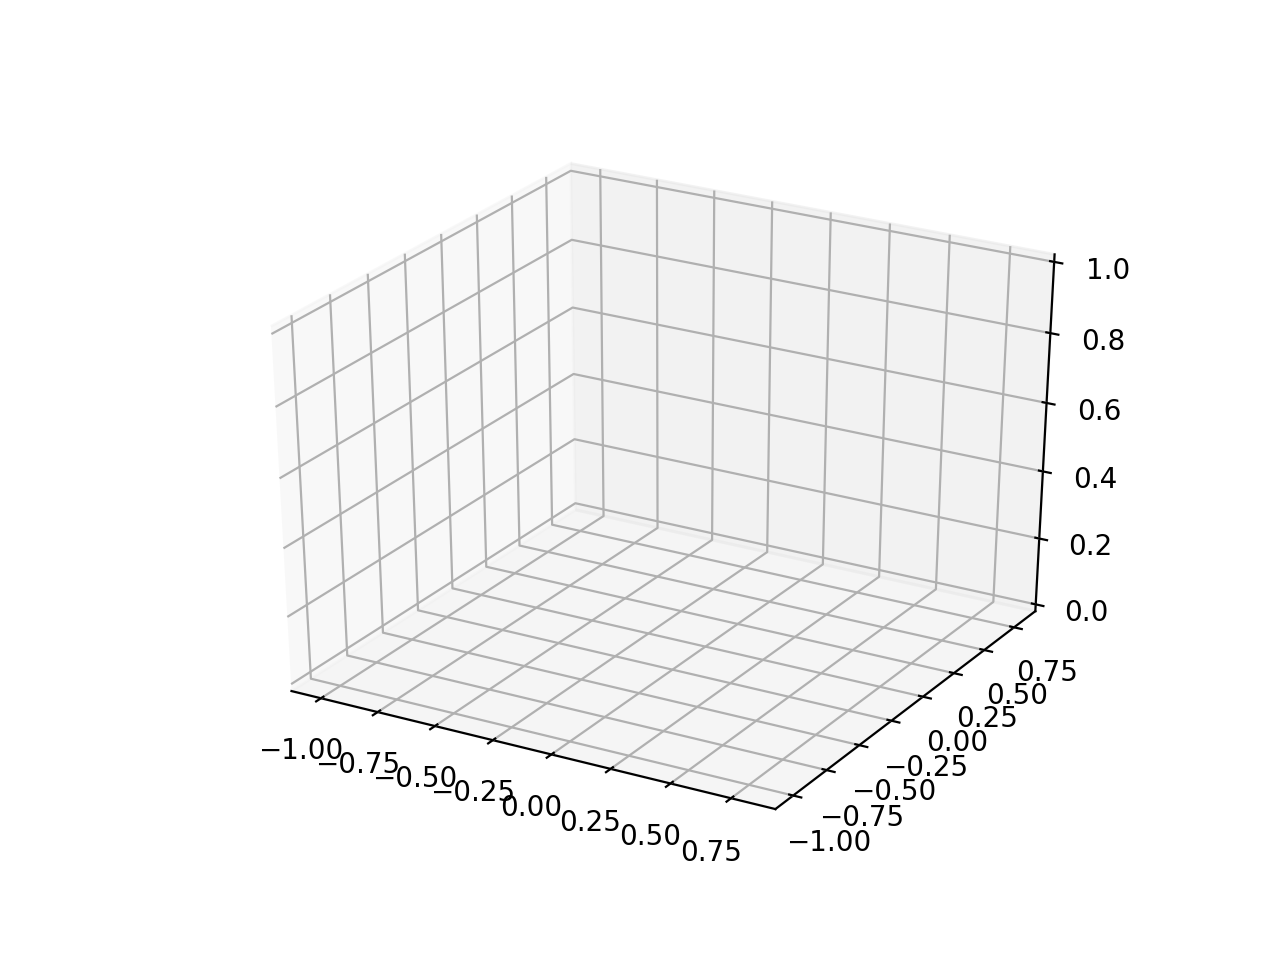

(None, None)

In [34]:

# output heatmap (brute force)
# replace None with the relative path if you want to save the plot
fair_model.heatmapflag = True
fair_model.save_heatmap(fair_model.max_iters, data_set, dataset_yhat.labels, None, None)






In [ ]:
# auditing a classifier for unfairness
# instantiate auditor
auditor = Auditor(data_set, 'FP')
group = auditor.get_group(dataset_yhat.labels, auditor.get_baseline(array_to_tuple(data_set.labels), array_to_tuple(dataset_yhat.labels)))
print('gamma disparity: {}'.format(group.weighted_disparity))






In [35]:
# run & create pareto curves
fair_model.max_iters = 10
fair_model.printflag = False
gamma_list = [.01, .02, .03, 1.0]
fair_model.pareto(data_set, gamma_list)



iteration: 1
most accurate classifier error: 0.185, most accurate class unfairness: 0.02205882352941177, violated group size: 0.39
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 1
most accurate classifier error: 0.185, most accurate class unfairness: 0.02205882352941177, violated group size: 0.39
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 1
most accurate classifier error: 0.185, most accurate class unfairness: 0.02205882352941177, violated group size: 0.39
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 1
most accurate classifier error: 0.185, most accurate class unfairness: 0.02205882352941177, violated group size: 0.39
iteration: 2
iteration: 3
iteration: 4
iteration: 5


([0.2227777777777778, 0.21055555555555558, 0.185, 0.185],
 [0.004084967320261439,
  0.0062636165577342065,
  0.02205882352941177,
  0.02205882352941177],
 [0.0, 0.0057446808510638455, 0.018191489361702128, 0.018191489361702128])

In [ ]:
def multiple_classifiers_pareto(dataset, gamma_list=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], save_results=False):

    ln_predictor = linear_model.LinearRegression()
    svm_predictor = svm.LinearSVR()
    tree_predictor = tree.DecisionTreeRegressor(max_depth=3)
    kernel_predictor = KernelRidge(alpha=1.0, gamma=1.0, kernel='rbf')
    predictor_dict = {'Linear': {'predictor': ln_predictor, 'iters': 10},
                      'SVR': {'predictor': svm_predictor, 'iters': 10},
                      'Tree': {'predictor': tree_predictor, 'iters': 10},
                      'Kernel': {'predictor': kernel_predictor, 'iters': 10}}

    results_dict = {}

    for pred in predictor_dict:
        print('Curr Predictor: {}'.format(pred))
        predictor = predictor_dict[pred]['predictor']
        max_iters = predictor_dict[pred]['iters']
        fair_clf = Model(C=100, printflag=True, gamma=1, predictor=predictor, max_iters=max_iters)
        fair_clf.set_options(max_iters=max_iters)
        errors, fp_violations, fn_violations = fair_clf.pareto(dataset, gamma_list)
        results_dict[pred] = {'errors': errors, 'fp_violations': fp_violations, 'fn_violations': fn_violations}
        plt.plot(errors, fp_violations, label=pred)

    if save_results:
        pickle.dump(results_dict, open('results_dict_' + str(gamma_list) + '_gammas' + str(gamma_list) + '.pkl', 'wb'))

    plt.xlabel('Error')
    plt.ylabel('Unfairness')
    plt.legend()
    plt.title('Error vs. Unfairness\n(Communities & Crime Dataset)')
    plt.show()
    
    
multiple_classifiers_pareto(data_set)

In [ ]:

def fp_vs_fn(dataset, fair_model, gamma_list):
    fp_auditor = Auditor(dataset, 'FP')
    fn_auditor = Auditor(dataset, 'FN')
    fp_violations = []
    fn_violations = []
    for g in gamma_list:
        fair_model.set_options(gamma=g)
        fair_model.fit(dataset)
        predictions = (fair_model.predict(dataset)).labels
        predictions_inv = [abs(1 - p) for p in predictions]
        _, fp_diff = fp_auditor.audit(predictions)
        _, fn_diff = fn_auditor.audit(predictions_inv)
        fp_violations.append(fp_diff)
        fn_violations.append(fn_diff)

    print((fp_violations, fn_violations))

    plt.plot(fp_violations, fn_violations, label='communities')
    plt.xlabel('False Positive Disparity')
    plt.ylabel('False Negative Disparity')
    plt.legend()
    plt.title('FP vs FN Unfairness')
    plt.show()
    
C = 10
print_flag = True
gamma = .01
max_iterations = 10
fair_def = 'FP'
fair_model = Model(C=C, printflag=print_flag, gamma=gamma, fairness_def=fair_def,
             max_iters=max_iterations)
data_set = load_preproc_data_adult(sub_samp=50)
gamma_list = [0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.05]
fp_vs_fn(data_set, fair_model, gamma_list)

NameError: name 'load_preproc_data_adult' is not defined